In [1]:
pip install tsam openpyxl seaborn

   ---------------------------------------- 0.0/3.9 MB ? eta -:--:--
   ---------------------------------------- 3.9/3.9 MB 74.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 13.6 MB/s eta 0:00:00

   ---------------------------------------- 0/3 [pyomo]
   ---------------------------------------- 0/3 [pyomo]
   ---------------------------------------- 0/3 [pyomo]
   ---------------------------------------- 0/3 [pyomo]
   ---------------------------------------- 0/3 [pyomo]
   ---------------------------------------- 0/3 [pyomo]
   ---------------------------------------- 0/3 [pyomo]
   ---------------------------------------- 0/3 [pyomo]
   ---------------------------------------- 0/3 [pyomo]
   ---------------------------------------- 0/3 [pyomo]
   ---------------------------------------- 0/3 [pyomo]
   ---------------------------------------- 0/3 [pyomo]
   --------------------------------

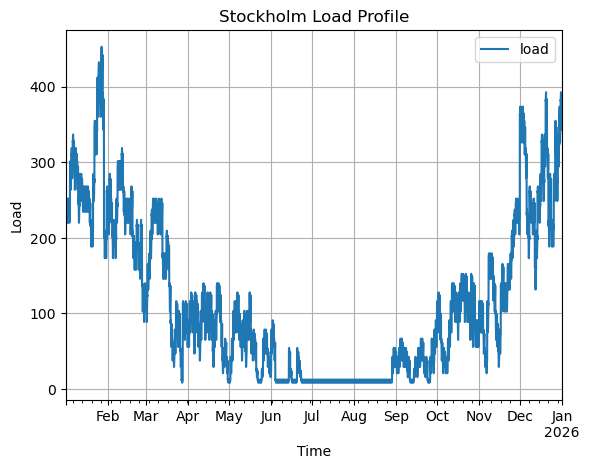

In [1]:
import tsam.timeseriesaggregation as tsam, pandas as pd, matplotlib.pyplot as plt
path = 'C:\\Users\\akoek\\OneDrive - TU Wien\\Desktop\\PhD\\Capacity Expansion\\Code\\LoadProfile.xlsx'

df = pd.read_excel(path)


date = pd.to_datetime("2025-01-01 00:00")
index = pd.date_range(date, periods=len(df), freq='h').tz_localize('utc').tz_convert(tz='Europe/Stockholm')
df.index = index

df.plot()
plt.grid()
plt.ylabel('Load')
plt.xlabel('Time')
plt.title('Stockholm Load Profile')
df.rename(columns = {'Load Profile':'Original'}, inplace = True)

In [6]:
def cluster_data(n_typical_days):
    aggregation = tsam.TimeSeriesAggregation(df, noTypicalPeriods=n_typical_days,
                                                    hoursPerPeriod=7*24, 
                                                    clusterMethod='adjacent_periods', 
                                                    extremePeriodMethod='replace_cluster_center')
    typPeriods = aggregation.createTypicalPeriods()
    metrics = aggregation.accuracyIndicators()
    return(metrics["RMSE"].iloc[0])

import random, numpy as np
seed = 42
random.seed(seed)
np.random.seed(seed)


list_day = []
list_error = []
for n_days in range(1,13):
    error = float(cluster_data(n_days))
    list_day += [n_days]
    list_error += [error]
    print(f"{n_days} : {error}")

1 : 0.2380658917543744
2 : 0.21877038022153056
3 : 0.12542198463781123
4 : 0.1310675761977302
5 : 0.10212252540165533
6 : 0.09700024347621271
7 : 0.08751244298182462
8 : 0.084609445652114
9 : 0.08383348629615968
10 : 0.0807752807615742
11 : 0.07608487229055359
12 : 0.070764826148392


Text(0, 0.5, 'RMSE (%)')

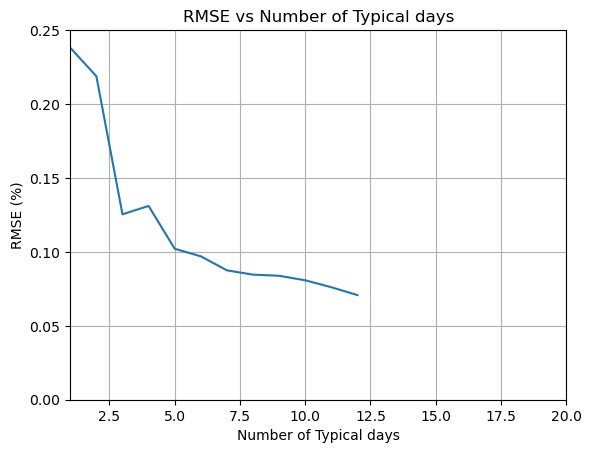

In [7]:
plt.plot(list_day,list_error)
plt.xlim(1,20)
plt.ylim(0,0.25)
plt.grid()
plt.title('RMSE vs Number of Typical days')
plt.xlabel('Number of Typical days')
plt.ylabel('RMSE (%)')

In [9]:
# number of typical periods
n_typical_periods = 4

aggregation = tsam.TimeSeriesAggregation(df, noTypicalPeriods=n_typical_periods,
                                                hoursPerPeriod=7*24, 
                                                clusterMethod='adjacent_periods', 
                                                extremePeriodMethod='replace_cluster_center')
typPeriods = aggregation.createTypicalPeriods()
metrics = aggregation.accuracyIndicators()

In [10]:
# 1) convert dict to Series
w_abs = pd.Series(aggregation.clusterPeriodNoOccur, dtype=float)
w_abs.index.name = 'Typical Week'
w_abs.name = 'weight_abs'

# 2) relative weights
w_rel = (w_abs / w_abs.sum()).rename('weight_rel')

# 3) combine
weights = pd.concat([w_abs, w_rel], axis=1).reset_index()

# 4) join with typical weeks DataFrame
df3 = typPeriods.reset_index().rename(columns={'level_0': 'Typical Week'})
df3 = df3.merge(weights, on='Typical Week', how='left')
print(df3)

     Typical Week  TimeStep        load  weight_abs  weight_rel
0               0         0   11.897728        29.0    0.556164
1               0         1   11.897728        29.0    0.556164
2               0         2   11.897728        29.0    0.556164
3               0         3   12.491291        29.0    0.556164
4               0         4   13.084854        29.0    0.556164
..            ...       ...         ...         ...         ...
667             3       163  134.468495         7.0    0.134247
668             3       164  138.524509         7.0    0.134247
669             3       165  140.404126         7.0    0.134247
670             3       166  140.107344         7.0    0.134247
671             3       167  138.524509         7.0    0.134247

[672 rows x 5 columns]


In [13]:
match = aggregation.indexMatching()  # same shape as original df; columns: 'stepIdx', 'clusterPeriodIdx', ...
mapping = pd.DataFrame({
    'timestamp': df.index,
    'typical_week_id': match['PeriodNum'].to_numpy(),  # 0..W-1
    'hour_in_week': match['TimeStep'].to_numpy()               # 1..168
})

ValueError: All arrays must be of the same length

In [12]:
match

,PeriodNum,TimeStep
2025-01-01 01:00:00+01:00,1,0
2025-01-01 02:00:00+01:00,1,1
2025-01-01 03:00:00+01:00,1,2
2025-01-01 04:00:00+01:00,1,3
2025-01-01 05:00:00+01:00,1,4
...,...,...
2025-01-06 20:00:00+01:00,2,163
2025-01-06 21:00:00+01:00,2,164
2025-01-06 22:00:00+01:00,2,165
2025-01-06 23:00:00+01:00,2,166


                                 load  Prediction
2025-01-01 01:00:00+01:00  245.140777  296.214423
2025-01-01 02:00:00+01:00  244.880266  295.521933
2025-01-01 03:00:00+01:00  245.488125  296.214423
2025-01-01 04:00:00+01:00  247.919560  299.676874
2025-01-01 05:00:00+01:00  248.180071  299.676874
...                               ...         ...
2025-12-31 20:00:00+01:00  367.059888  417.004501
2025-12-31 21:00:00+01:00  376.611955  427.886491
2025-12-31 22:00:00+01:00  383.298402  435.503883
2025-12-31 23:00:00+01:00  383.298402  435.503883
2026-01-01 00:00:00+01:00  376.611955  427.886491

[8760 rows x 2 columns]


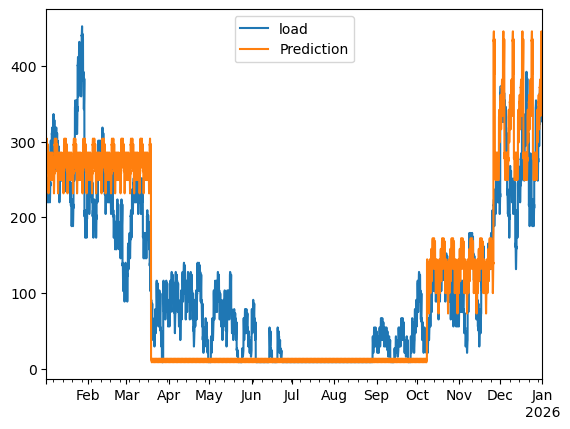

In [263]:
df2 = df.copy()
df2['Prediction'] = aggregation.predictOriginalData()
df2['Prediction'].name = 'Aggregated (TSAM)'
df2.plot()
print(df2)

(0.0, 167.0)

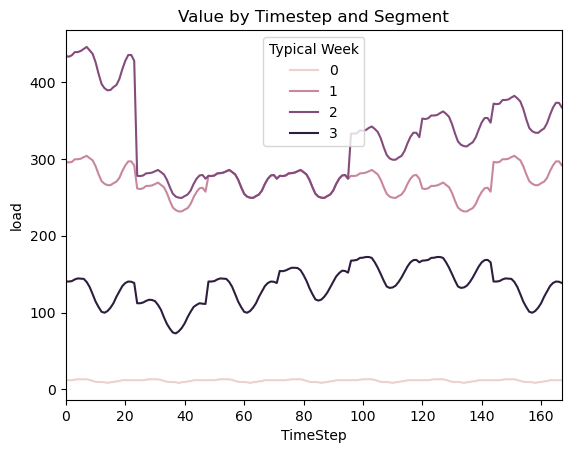

In [288]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    data=df3,
    x='TimeStep',
    y='load',
    hue='Typical Week',
    #marker='o'
)
plt.title('Value by Timestep and Segment')
plt.xlim(0,7*24-1)

In [289]:
df3.to_csv('typical_weeks.csv', index=False, sep=',', decimal='.',  header=True)